# Notebook to correct quenching from a glider dataset

The idea is to leverage the number of observation in a glider dataset to achieve a quenching correction using the night time profile as our training dataset of "unquenched profiles".

1) Binary classification of quenched profiles. The mid-day profiles will be labelled as quenched and mid-night profiles will be labeled as unquenched to predict if dusk and dawn profiles are quenched. 
2) Second binary classification to predict the quenched layer depth based on F/bbp values. 
3) Predict a F/bbp factor based on bbp, T, S, depth, Doy. Training is realised on the "unquenched database" and new prediction is made on quenched layers. 
4) Apply the ratio predicted before on the quench layer

## 1. Building the dataset 

Open the gliders dataset. I want to end up with one tidy table composed of profile id, doy, time, depth, T, S, F, bbp.
I will further derive a "day_period" variable that will correspond to mid-day, dusk, mid-night or dawn. TBD what time lag should be before/after sunset and sunset to consider mid-day or mid-night.

In [1]:
import xarray as xr
import polars as pl
import glob

# Get list of NetCDF files
nc_files = glob.glob("C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled/*.nc")

# Read and concatenate datasets
for file in nc_files:
    ds = xr.open_dataset(file, decode_times=True)
    glider_name = ds.attrs.get("trajectory").split("_")[0]
    # Select variables of interest
    vars_of_interest = ["TIME", "DEPTH", "TEMP", "CHLA", "BBP700", "ABS_SALINITY", "PROFILE_NUMBER", "LATITUDE", "LONGITUDE"]
    ds_sel = ds[vars_of_interest]
    # Convert to pandas DataFrame, then to polars DataFrame
    df_pd = ds_sel.to_dataframe().reset_index()
    df_pl = pl.from_pandas(df_pd)

    #Use only profiling data (-1 is surfacing behavior)
    df_pl = df_pl.filter(pl.col("PROFILE_NUMBER") > 0)

    df_pl = df_pl.with_columns((pl.col("PROFILE_NUMBER").cast(pl.String) + "_" + glider_name).alias("profile_id"))
    print(f"{file} processed, shape: {df_pl.shape}")

    # Concatenate DataFrames
    if 'df_concat' in locals():
        df_concat = pl.concat([df_concat, df_pl])
    else:
        df_concat = df_pl

C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Cabot_645_Profiled.nc processed, shape: (1438541, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Churchill_647_Profiled.nc processed, shape: (1142019, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Doombar_648_Profiled.nc processed, shape: (1952630, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Nelson_646_Profiled.nc processed, shape: (1951435, 11)


In [2]:
# Interpolate DEPTH, TEMP, and ABS_SALINITY per profile_id along TIME
df_concat = (
    df_concat
    .sort(["profile_id", "TIME"])
    .with_columns([
        pl.col("DEPTH").interpolate().over("profile_id").alias("DEPTH_interp"),
        pl.col("TEMP").interpolate().over("profile_id").alias("TEMP_interp"),
        pl.col("ABS_SALINITY").interpolate().over("profile_id").alias("ABS_SALINITY_interp"),
    ])
)

In [3]:
# Count rows where CHLA and BBP700 are not null, but at least one of the interp columns is null
count = (
    df_concat
    .filter(
        (pl.col("CHLA").is_not_null()) &
        (pl.col("BBP700").is_not_null()) &
        (pl.col("LATITUDE").is_not_null()) &
        (pl.col("LONGITUDE").is_not_null()) &
        (
            pl.col("DEPTH_interp").is_null() |
            pl.col("TEMP_interp").is_null() |
            pl.col("ABS_SALINITY_interp").is_null()
        )
    )
    .height
)
print(f"Number of rows with CHLA and BBP700 but missing one interp variable: {count}")

Number of rows with CHLA and BBP700 but missing one interp variable: 8451


In [4]:
# Filter out rows with NA in required columns and drop original columns
df_filtered = (
    df_concat
    .filter(
        pl.col("CHLA").is_not_null() &
        pl.col("BBP700").is_not_null() &
        pl.col("DEPTH_interp").is_not_null() &
        pl.col("TEMP_interp").is_not_null() &
        pl.col("ABS_SALINITY_interp").is_not_null() &
        (pl.col("LATITUDE").is_not_null()) &
        (pl.col("LONGITUDE").is_not_null())
    )
    .drop(["DEPTH", "TEMP", "ABS_SALINITY"])
    .rename({
        "DEPTH_interp": "DEPTH",
        "TEMP_interp": "TEMP",
        "ABS_SALINITY_interp": "ABS_SALINITY"
    })
)

In [5]:
# Filter profiles with more than 100 observations
profile_counts = (
    df_filtered
    .group_by("profile_id")
    .agg([
        pl.len().alias("n_obs"),
        pl.col("DEPTH").min().alias("min_depth"),
        pl.col("DEPTH").max().alias("max_depth"),
        pl.col("DEPTH").abs().min().alias("min_abs_depth"),
        pl.col("DEPTH").abs().max().alias("max_abs_depth"),
    ])
)

# Apply filtering conditions
valid_profiles = (
    profile_counts
    .filter(
        (pl.col("n_obs") > 100)
    )
    .select("profile_id")
    .to_series()
    .to_list()
)

df_filtered = df_filtered.filter(pl.col("profile_id").is_in(valid_profiles))

In [6]:
import datetime

df_filtered = (
    df_filtered
    .with_columns([
        pl.col("TIME").dt.date().alias("DATE"),
        pl.col("TIME").dt.ordinal_day().alias("DOY"),
        pl.col("TIME").dt.time().alias("TIME_ONLY"),
    ])
)

In [7]:
from astral.sun import sun
from astral import LocationInfo
import pytz

# Step 1: Compute unique dates with average lat/lon
date_latlon = (
    df_filtered
    .groupby("DATE")
    .agg([
        pl.col("LATITUDE").mean().alias("LAT_MEAN"),
        pl.col("LONGITUDE").mean().alias("LON_MEAN")
    ])
)

# Step 2: Compute sunrise and sunset for each date/lat/lon
def compute_sun_times(row):
    date = row["DATE"]
    lat = row["LAT_MEAN"]
    lon = row["LON_MEAN"]
    try:
        location = LocationInfo(latitude=lat, longitude=lon)
        s = sun(location.observer, date=date, tzinfo=pytz.UTC)
        return s["sunrise"].time().isoformat(), s["sunset"].time().isoformat()
    except Exception:
        return None, None

rows = date_latlon.to_dicts()
sun_times = [compute_sun_times(row) for row in rows]
sunrise_list, sunset_list = zip(*sun_times)

date_latlon = date_latlon.with_columns([
    pl.Series("SUNRISE", sunrise_list),
    pl.Series("SUNSET", sunset_list),
])

date_latlon = date_latlon.with_columns([
    pl.col("SUNRISE").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNRISE"),
    pl.col("SUNSET").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNSET"),
])

# Step 3: Left join sunrise/sunset info to df_filtered
df_with_sun = df_filtered.join(date_latlon.select(["DATE", "SUNRISE", "SUNSET"]), on="DATE", how="left")

C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\1053173047.py:8: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby("DATE")
C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\1053173047.py:37: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("SUNRISE").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNRISE"),
C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\1053173047.py:38: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("SUNSET").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNSET"),


In [8]:
import datetime

def get_day_period(row):
    time_only = row["TIME_ONLY"]
    sunrise = row["SUNRISE"]
    sunset = row["SUNSET"]

    # If any value is None, return null
    if time_only is None or sunrise is None or sunset is None:
        return None

    # Convert to datetime.time if needed
    if not isinstance(time_only, datetime.time):
        try:
            time_only = datetime.time.fromisoformat(str(time_only))
        except Exception:
            return None
    if not isinstance(sunrise, datetime.time):
        try:
            sunrise = datetime.time.fromisoformat(str(sunrise))
        except Exception:
            return None
    if not isinstance(sunset, datetime.time):
        try:
            sunset = datetime.time.fromisoformat(str(sunset))
        except Exception:
            return None

    def seconds_diff(t1, t2):
        dt1 = datetime.datetime.combine(datetime.date(1,1,1), t1)
        dt2 = datetime.datetime.combine(datetime.date(1,1,1), t2)
        return (dt1 - dt2).total_seconds()

    two_hours = 2 * 3600
    one_hour = 2 * 3600

    if -one_hour <= seconds_diff(time_only, sunrise) <= one_hour:
        return "dawn"
    elif -one_hour <= seconds_diff(sunset, time_only) <= one_hour:
        return "dusk"
    elif seconds_diff(time_only, sunset) > one_hour or seconds_diff(time_only, sunrise) < -one_hour:
        return "mid-night"
    else:
        return "mid-day"

df_with_sun = df_with_sun.with_columns(
    pl.struct(["TIME_ONLY", "SUNRISE", "SUNSET"]).apply(get_day_period).alias("day_period")
)

C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\2194705706.py:47: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.struct(["TIME_ONLY", "SUNRISE", "SUNSET"]).apply(get_day_period).alias("day_period")


In [9]:
# Count unique profile_id per day_period in df_filtered
profile_count = (
    df_with_sun
    .group_by("day_period")
    .agg([
        pl.col("profile_id").n_unique().alias("n_profiles")
    ])
    .sort("day_period")
)

profile_count

shape: (5, 2)
┌────────────┬────────────┐
│ day_period ┆ n_profiles │
│ ---        ┆ ---        │
│ str        ┆ u32        │
╞════════════╪════════════╡
│ null       ┆ 40         │
│ dawn       ┆ 1107       │
│ dusk       ┆ 1015       │
│ mid-day    ┆ 2670       │
│ mid-night  ┆ 1018       │
└────────────┴────────────┘

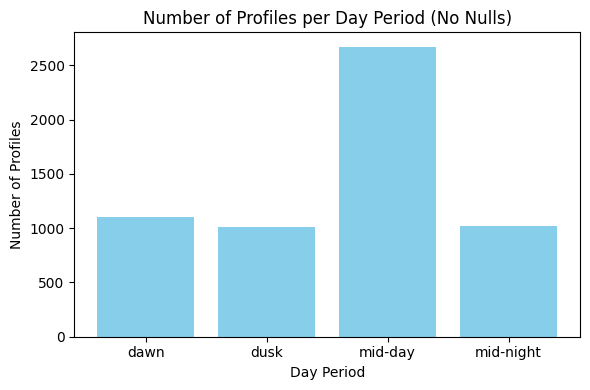

In [10]:
# Remove rows with null day_period
df_no_null = df_with_sun.filter(pl.col("day_period").is_not_null())

# Count unique profile_id per day_period
profile_count_no_null = (
    df_no_null
    .group_by("day_period")
    .agg([
        pl.col("profile_id").n_unique().alias("n_profiles")
    ])
    .sort("day_period")
)

# Bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(profile_count_no_null["day_period"], profile_count_no_null["n_profiles"], color="skyblue")
plt.xlabel("Day Period")
plt.ylabel("Number of Profiles")
plt.title("Number of Profiles per Day Period (No Nulls)")
plt.tight_layout()
plt.show()

## Smoothing Chla and BBP profiles

In [11]:
df_with_sun = df_with_sun.sort(["profile_id", "DEPTH"])

In [12]:
import glidertools as gt
bbp_baseline, bbp_spikes = gt.cleaning.despike(df_with_sun['BBP700'], 7, spike_method='minmax')

C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [13]:

# Despike BBP700
bbp_baseline, _ = gt.cleaning.despike(df_with_sun['BBP700'], 7, spike_method='minmax')
# Despike CHLA
chla_baseline, _ = gt.cleaning.despike(df_with_sun['CHLA'], 7, spike_method='minmax')

chla_nodark = gt.optics.fluorescence_dark_count(chla_baseline, abs(df_with_sun["DEPTH"]))

# Add new columns to df_with_sun
df_with_sun = df_with_sun.with_columns([
    pl.Series("bbp_clean", bbp_baseline),
    pl.Series("chla_clean", chla_nodark)
])



In [14]:
import numpy as np

# Get one random profile_id for each day_period
selected_profiles = []
for period in ["mid-day", "mid-night", "dawn", "dusk"]:
    ids = (
        df_with_sun
        .filter(pl.col("day_period") == period)
        .select("profile_id")
        .unique()
        .to_series()
        .to_list()
    )
    if ids:
        selected_profiles.append(np.random.choice(ids))

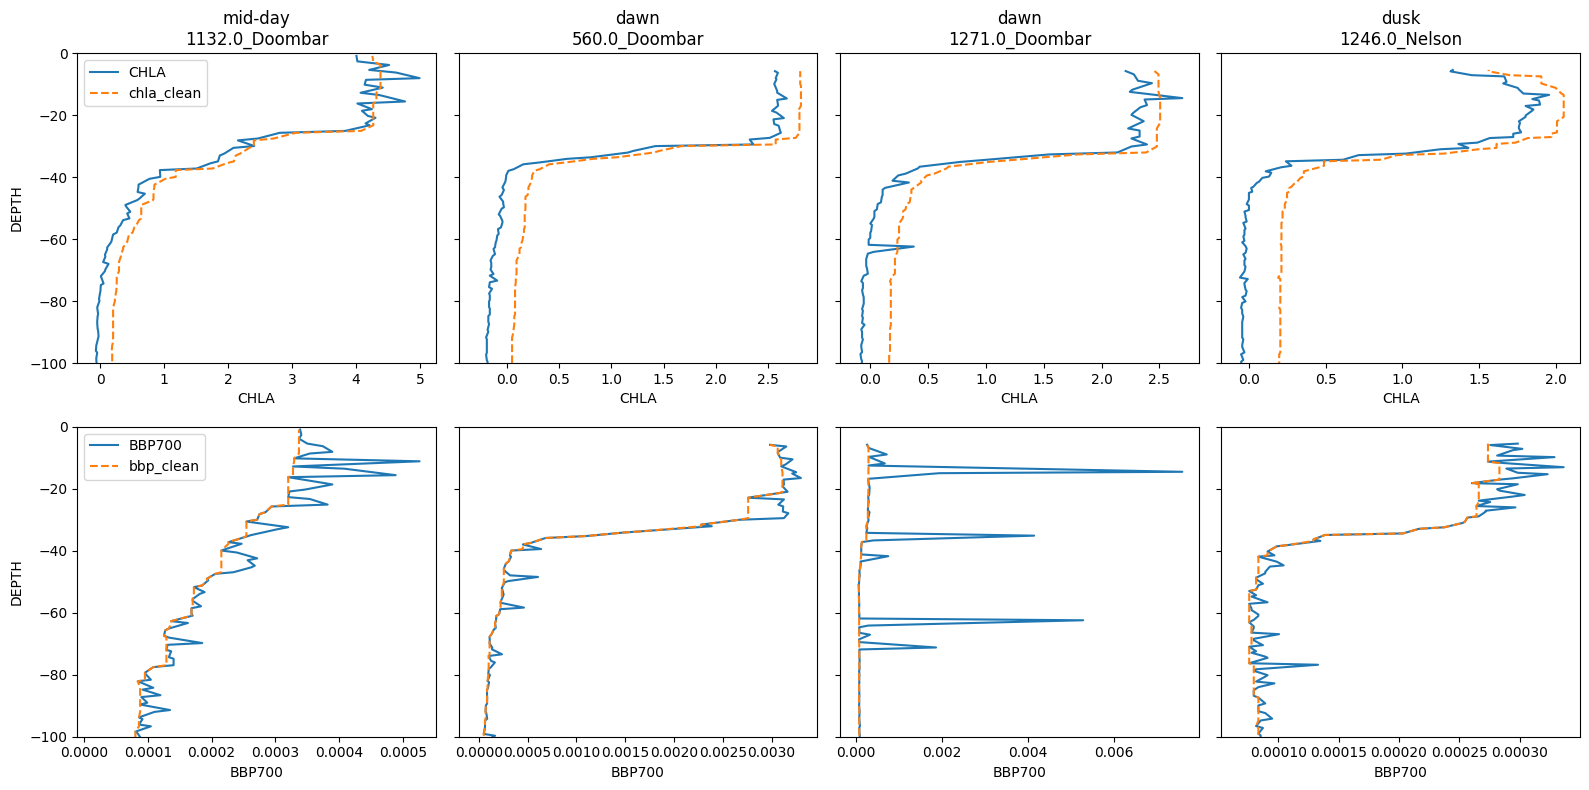

In [15]:
# Plot CHLA/chla_clean and BBP700/bbp_clean vs DEPTH for each selected profile, in two rows

fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for i, profile_id in enumerate(selected_profiles):
    prof = df_with_sun.filter(pl.col("profile_id") == profile_id)
    # Top row: CHLA
    axs[0, i].plot(prof["CHLA"], prof["DEPTH"], label="CHLA", color="tab:blue")
    axs[0, i].plot(prof["chla_clean"], prof["DEPTH"], label="chla_clean", color="tab:orange", linestyle="--")
    axs[0, i].set_title(f"{prof['day_period'][0]}\n{profile_id}")
    axs[0, i].invert_yaxis()
    axs[0, i].set_ylim(-100, 0)
    if i == 0:
        axs[0, i].set_ylabel("DEPTH")
    axs[0, i].set_xlabel("CHLA")
    if i == 0:
        axs[0, i].legend()

    # Bottom row: BBP700
    axs[1, i].plot(prof["BBP700"], prof["DEPTH"], label="BBP700", color="tab:blue")
    axs[1, i].plot(prof["bbp_clean"], prof["DEPTH"], label="bbp_clean", color="tab:orange", linestyle="--")
    axs[1, i].invert_yaxis()
    axs[1, i].set_ylim(-100, 0)
    if i == 0:
        axs[1, i].set_ylabel("DEPTH")
    axs[1, i].set_xlabel("BBP700")
    if i == 0:
        axs[1, i].legend()

plt.tight_layout()
plt.show()

In [16]:
# Add rounded depth column
df_with_sun = df_with_sun.with_columns([
    pl.col("DEPTH").round(0).cast(pl.Int32).alias("DEPTH_ROUND")
])

# Remove depths below -200
df_with_sun = df_with_sun.filter(pl.col("DEPTH_ROUND") >= -40)
df_with_sun = df_with_sun.filter(pl.col("DEPTH_ROUND") < -2)

df_with_sun = df_with_sun.with_columns(
    (pl.col("chla_clean") / pl.col("bbp_clean")).alias("chla_bbp_ratio")
)

# Find profiles where max(DEPTH_ROUND) > 0
profiles_to_remove = (
    df_with_sun
    .groupby("profile_id")
    .agg(pl.col("DEPTH_ROUND").max().alias("max_round_depth"))
    .filter(pl.col("max_round_depth") > 0)
    .select("profile_id")
    .to_series()
    .to_list()
)

# Filter out those profiles
df_depth_filtered = df_with_sun.filter(~pl.col("profile_id").is_in(profiles_to_remove))

C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\3832075399.py:17: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby("profile_id")


In [17]:
import gsw

def compute_mld(profile):
    # Sort by increasing depth (should already be sorted, but just in case)
    profile = profile.sort("DEPTH")
    depth = profile["DEPTH"].to_numpy()
    temp = profile["TEMP"].to_numpy()
    abs_sal = profile["ABS_SALINITY"].to_numpy()
    # Use mean latitude for the profile (required by gsw)
    lat = profile["LATITUDE"].mean()
    # Calculate pressure from depth (depth is negative, so take abs)
    p = gsw.p_from_z(-depth, lat)
    # Calculate potential density anomaly (sigma0)
    sigma0 = gsw.sigma0(abs_sal, temp)
    # MLD: depth where sigma0 increases by 0.005 kg/m3 from the shallowest value
    ref_sigma0 = sigma0[0]
    mld_idx = np.argmax(sigma0 - ref_sigma0 > 0.005)
    if (sigma0 - ref_sigma0 > 0.005).any():
        mld = depth[mld_idx]
    else:
        mld = np.nan
    return mld

# Compute MLD for each profile_id using map_groups
def compute_mld_group(df):
    mld = compute_mld(df)
    return pl.DataFrame({"profile_id": [df["profile_id"][0]], "MLD": [mld]})

mld_df = (
    df_depth_filtered
    .groupby("profile_id")
    .map_groups(compute_mld_group)
)

# Join MLD back to df_depth_filtered
df_depth_filtered = df_depth_filtered.join(mld_df, on="profile_id", how="left")

C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\239453366.py:31: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby("profile_id")


In [18]:
import numpy as np

# Remove inf values in chla_bbp_ratio and normalise per profile
df_depth_filtered = (
    df_depth_filtered
    .filter(~pl.col("chla_bbp_ratio").is_in([np.inf, -np.inf, None]))  # remove inf/nulls
    .with_columns([
        (
            (pl.col("chla_bbp_ratio") - pl.col("chla_bbp_ratio").min().over("profile_id")) /
            (pl.col("chla_bbp_ratio").max().over("profile_id") - pl.col("chla_bbp_ratio").min().over("profile_id"))
        ).alias("chla_bbp_ratio_norm")
    ])
)

In [19]:


# Group, average, and sort by DEPTH_ROUND before pivoting
fluo_table = (
    df_depth_filtered
.groupby(["profile_id", "DEPTH_ROUND"])
    .agg([
        pl.col("chla_bbp_ratio_norm").mean().alias("chla_mean")
    ])
    .sort(["profile_id", "DEPTH_ROUND"])
)

# Pivot to wide format
fluo_table_wide = fluo_table.pivot(
    values="chla_mean",
    index="profile_id",
    columns="DEPTH_ROUND"
)

# Interpolate missing values along each row (profile)
fluo_table_pd = fluo_table_wide.to_pandas().set_index("profile_id")
fluo_table_pd = fluo_table_pd.apply(lambda row: row.interpolate(method="linear", limit_direction="both"), axis=1)
fluo_table_pd = fluo_table_pd.dropna(axis=0, how="any")

fluo_table_final = pl.from_pandas(fluo_table_pd.reset_index())
fluo_table_final

C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\373700937.py:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["profile_id", "DEPTH_ROUND"])


shape: (4_309, 39)
┌─────────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ profile_id      ┆ -40      ┆ -39      ┆ -38      ┆ … ┆ -22      ┆ -9       ┆ -6       ┆ -14      │
│ ---             ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str             ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 10.0_Churchill  ┆ 0.0      ┆ 0.259803 ┆ 0.89614  ┆ … ┆ 0.986368 ┆ 0.986368 ┆ 0.986368 ┆ 0.986368 │
│ 10.0_Doombar    ┆ 0.0      ┆ 0.114392 ┆ 0.113393 ┆ … ┆ 0.924433 ┆ 0.924433 ┆ 0.924433 ┆ 0.924433 │
│ 10.0_Nelson     ┆ 0.0      ┆ 0.269882 ┆ 0.397585 ┆ … ┆ 0.867172 ┆ 1.0      ┆ 1.0      ┆ 1.0      │
│ 100.0_Churchill ┆ 0.411578 ┆ 0.411578 ┆ 0.428169 ┆ … ┆ 0.259911 ┆ 0.091652 ┆ 0.081077 ┆ 0.094885 │
│ 100.0_Doombar   ┆ 0.408509 ┆ 0.408509 ┆ 0.567308 ┆ … ┆ 0.0      ┆ 0.0      ┆ 0.59058  ┆ 0.0      │
│ …               ┆ …        ┆ …        ┆ …        ┆ … ┆ …        ┆ …        ┆ …        ┆ …        │
│ 997.0_Nelson    ┆ 0.282731 ┆ 0.543096 ┆ 0.648133 ┆ … ┆ 0.580633 ┆ 0.387681 ┆ 0.304813 ┆ 0.861859 │
│ 998.0_Doombar   ┆ 0.110404 ┆ 0.116387 ┆ 0.046946 ┆ … ┆ 0.621043 ┆ 0.810521 ┆ 1.0      ┆ 1.0      │
│ 998.0_Nelson    ┆ 0.333876 ┆ 0.554612 ┆ 0.775348 ┆ … ┆ 0.932752 ┆ 0.932752 ┆ 0.932752 ┆ 0.932752 │
│ 999.0_Doombar   ┆ 0.808921 ┆ 0.769106 ┆ 0.769106 ┆ … ┆ 0.282937 ┆ 0.193445 ┆ 0.474989 ┆ 0.756533 │
│ 999.0_Nelson    ┆ 0.306486 ┆ 0.317307 ┆ 0.328127 ┆ … ┆ 0.960465 ┆ 0.536933 ┆ 0.1134   ┆ 0.799744 │
└─────────────────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴──────────┴──────────┘

In [20]:
ca_data = fluo_table_pd.copy()
ca_data[ca_data <= 0] = 1e-6

import prince
# CA requires all values to be strictly positive and no NaNs
ca_data = fluo_table_pd.copy()
# Remove 'profile_id' column if present (should only be index)
ca_data = ca_data.reset_index(drop=True)

ca_data[ca_data <= 0] = 1e-6  # set all non-positive values to a small positive constant
ca_data = ca_data.dropna(axis=0, how="any").dropna(axis=1, how="any")

In [21]:
# Set all values <= 0 to a small positive constant
ca_data = fluo_table_pd.copy()
ca_data[ca_data <= 0] = 1e-6

ca_data = ca_data.replace([np.inf, -np.inf], 999)
ca_data[ca_data >=  1000] = 999


In [22]:
for col in ca_data.columns:
    col_vals = ca_data[col]
    finite_vals = col_vals[np.isfinite(col_vals)]
    
    if finite_vals.empty:
        continue  # skip if all values are inf or NaN

    max_val = finite_vals.max()
    min_val = finite_vals.min()

    ca_data.loc[col_vals == np.inf, col] = max_val
    ca_data.loc[col_vals == -np.inf, col] = min_val

C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\3234579340.py:24: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby("profile_id")


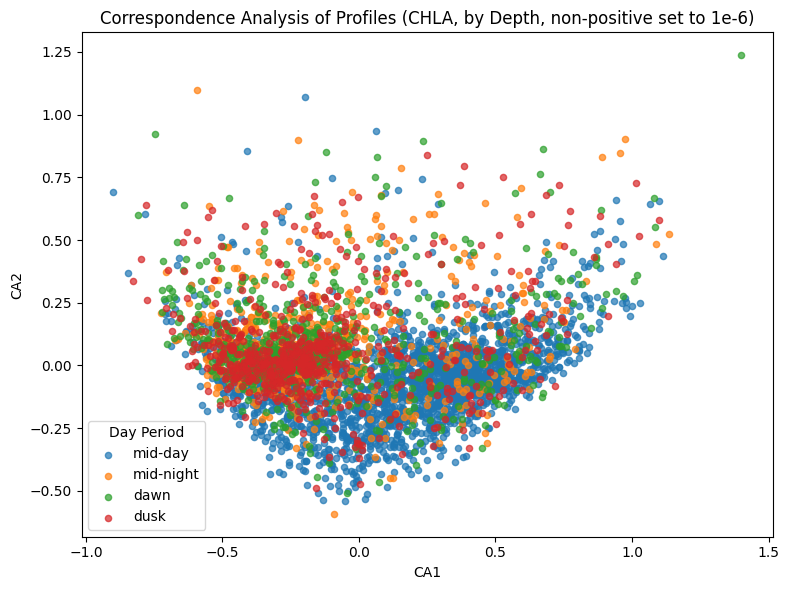

In [23]:

import prince
# CA requires all values to be strictly positive and no NaNs
ca_data = fluo_table_pd.copy()
# Add "depth" in front of all column names
ca_data.columns = ["depth" + str(col) for col in ca_data.columns]

# Remove 'profile_id' column if present (should only be index)
if "profile_id" in ca_data.columns:
    ca_data = ca_data.set_index("profile_id")

ca_data[ca_data <= 0] = 1e-6  # set all non-positive values to a small positive constant
ca_data = ca_data.dropna(axis=0, how="any").dropna(axis=1, how="any")

ca = prince.CA(n_components=4, n_iter=10, copy=True, check_input=True, engine='sklearn', random_state=42)
ca = ca.fit(ca_data)

# Get CA coordinates for each profile
ca_coords = ca.row_coordinates(ca_data)
ca_coords.index = ca_data.index

# Get day_period for each profile_id
profile_period = (
    df_with_sun
    .groupby("profile_id")
    .agg(pl.col("day_period").mode().alias("day_period_mode"))
    .explode("day_period_mode")  # Unwrap list
    .unique(subset=["profile_id"])  # Ensure only one row per profile_id
    .rename({"day_period_mode": "day_period"})
    .to_pandas()
    .set_index("profile_id")["day_period"]
)




# Align day_period with CA coordinates
ca_coords["day_period"] = ca_coords.index.map(profile_period)

# Plot CA1 vs CA2, colored by day_period
plt.figure(figsize=(8,6))
for period in ca_coords["day_period"].dropna().unique():
    mask = ca_coords["day_period"] == period
    plt.scatter(
        ca_coords.loc[mask, 0],
        ca_coords.loc[mask, 1],
        label=period,
        alpha=0.7,
        s=20
    )
plt.xlabel("CA1")
plt.ylabel("CA2")
plt.title("Correspondence Analysis of Profiles (CHLA, by Depth, non-positive set to 1e-6)")
plt.legend(title="Day Period")
plt.tight_layout()
plt.show()


In [24]:
# Add CA1 and CA2 to df_with_sun
# First, get CA coordinates for each profile_id as a DataFrame
ca_coords_df = ca_coords[[0, 1, 2, 3]].copy()
ca_coords_df.columns = ["CA1", "CA2", "CA3", "CA4"]
ca_coords_df["profile_id"] = ca_coords_df.index

# Convert to polars DataFrame for joining
ca_coords_pl = pl.from_pandas(ca_coords_df.reset_index(drop=True))

# Join CA1 and CA2 to df_with_sun
df_final = df_depth_filtered.join(ca_coords_pl, on="profile_id", how="left")

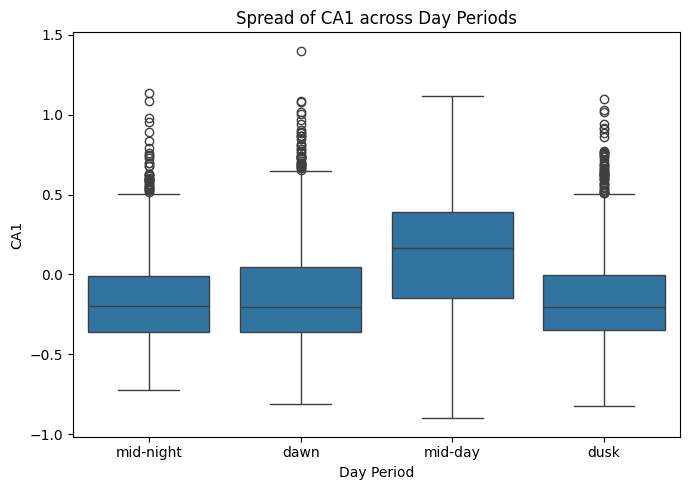

In [25]:
import seaborn as sns

# Prepare DataFrame for plotting: CA1 and day_period for each profile_id
ca1_dayperiod_df = (
    df_final
    .select(["profile_id", "CA1", "day_period"])
    .unique(subset=["profile_id"])
    .to_pandas()
)

plt.figure(figsize=(7, 5))
sns.boxplot(data=ca1_dayperiod_df, x="day_period", y="CA1", order=["mid-night", "dawn", "mid-day", "dusk"])
plt.xlabel("Day Period")
plt.ylabel("CA1")
plt.title("Spread of CA1 across Day Periods")
plt.tight_layout()
plt.show()

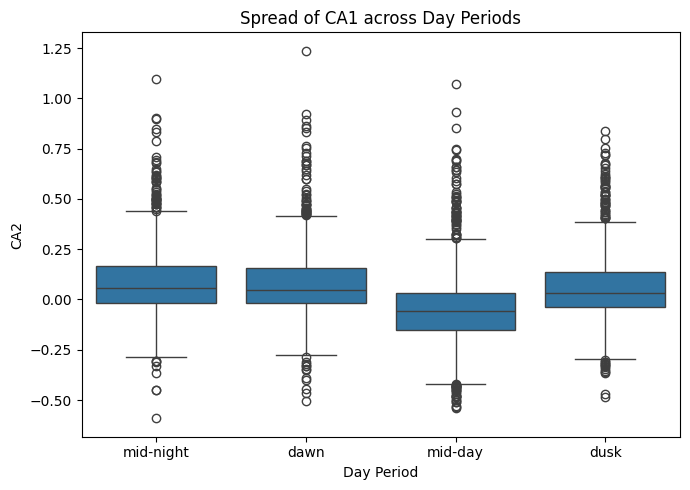

In [ ]:

# Prepare DataFrame for plotting: CA1 and day_period for each profile_id
ca1_dayperiod_df = (
    df_final
    .select(["profile_id", "CA2", "day_period"])
    .unique(subset=["profile_id"])
    .to_pandas()
)

plt.figure(figsize=(7, 5))
sns.boxplot(data=ca1_dayperiod_df, x="day_period", y="CA2", order=["mid-night", "dawn", "mid-day", "dusk"])
plt.xlabel("Day Period")
plt.ylabel("CA2")
plt.title("Spread of CA2 across Day Periods")
plt.tight_layout()
plt.show()

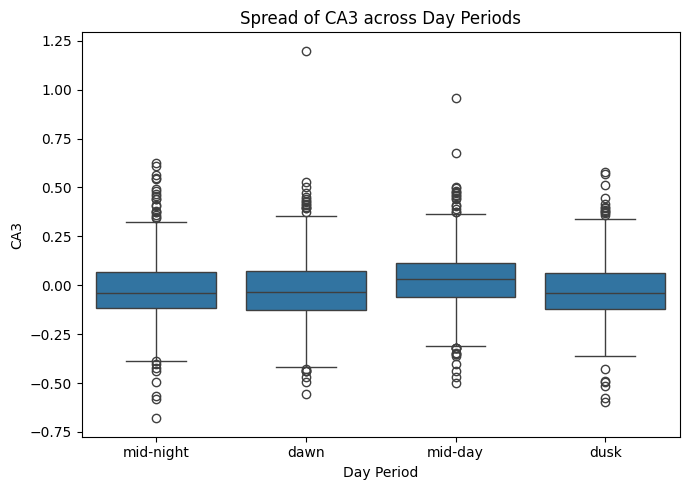

In [27]:
# Prepare DataFrame for plotting: CA1 and day_period for each profile_id
ca1_dayperiod_df = (
    df_final
    .select(["profile_id", "CA3", "day_period"])
    .unique(subset=["profile_id"])
    .to_pandas()
)

plt.figure(figsize=(7, 5))
sns.boxplot(data=ca1_dayperiod_df, x="day_period", y="CA3", order=["mid-night", "dawn", "mid-day", "dusk"])
plt.xlabel("Day Period")
plt.ylabel("CA3")
plt.title("Spread of CA3 across Day Periods")
plt.tight_layout()
plt.show()

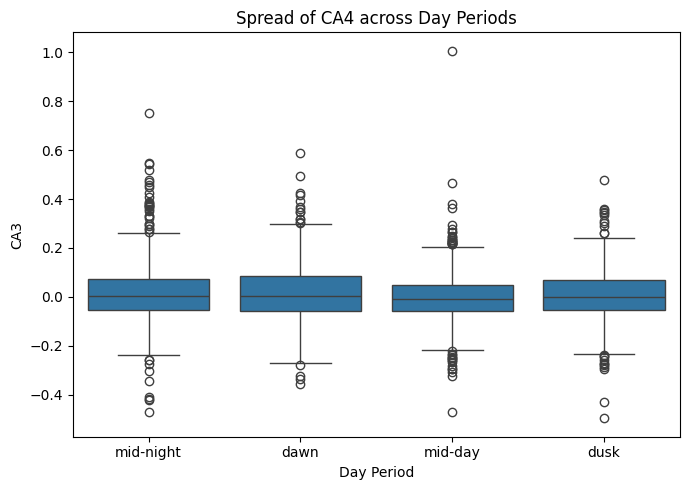

In [41]:
# Prepare DataFrame for plotting: CA1 and day_period for each profile_id
ca1_dayperiod_df = (
    df_final
    .select(["profile_id", "CA4", "day_period"])
    .unique(subset=["profile_id"])
    .to_pandas()
)

plt.figure(figsize=(7, 5))
sns.boxplot(data=ca1_dayperiod_df, x="day_period", y="CA4", order=["mid-night", "dawn", "mid-day", "dusk"])
plt.xlabel("Day Period")
plt.ylabel("CA3")
plt.title("Spread of CA4 across Day Periods")
plt.tight_layout()
plt.show()

In [28]:
# Now, for each target CA spot, find the closest profile, plot its fluorescence profile, and plot the mean profile of the 20 closest profiles
# Convert ca_coords to numpy for distance calculation
ca_coords_np = ca_coords[[0, 1]].to_numpy()
profile_ids = ca_coords.index.to_numpy()

# Define target CA spots
spots = [(-0.4, 0.3), (0.2, -0.2), (1.0, 0.4)]
spot_labels = ["(-0.4, 0.3)", "(0.2, -0.2)", "(1.0, 0.4)"]

In [29]:
# Normalise CHLA per profile in df_final
df_final = df_final.with_columns(
    (
        (pl.col("CHLA") - pl.col("CHLA").min().over("profile_id")) /
        (pl.col("CHLA").max().over("profile_id") - pl.col("CHLA").min().over("profile_id"))
    ).alias("CHLA_norm")
)

In [30]:
# Round CA1 to the nearest tenth
df_final = df_final.with_columns(
    pl.col("CA1").round(1).alias("CA1_round")
)

# Group by rounded CA1 and DEPTH_ROUND, then average chla_clean
chla_avg_by_ca1_depth = (
    df_final
    .groupby(["CA1_round", "DEPTH_ROUND"])
    .agg([
        pl.col("chla_bbp_ratio").mean().alias("chla_clean_mean")
    ])
    .sort(["CA1_round", "DEPTH_ROUND"])
)

C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\4082379719.py:9: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["CA1_round", "DEPTH_ROUND"])


In [31]:
# Extract CA1, CA2, CA3 for each unique profile
ca_features = (
    df_final
    .select(["profile_id", "CA1", "CA2", "CA3"])
    .unique(subset=["profile_id"])
    .to_pandas()
    .set_index("profile_id")
    .dropna()
)

In [32]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering



def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

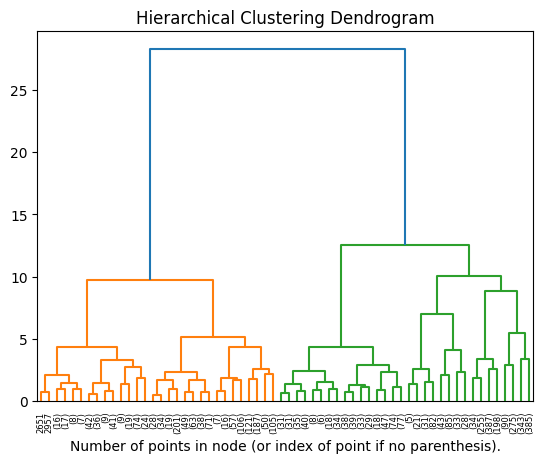

In [100]:
X = ca_features

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=5, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [101]:
# Assign cluster labels using the fitted AgglomerativeClustering model
cluster_labels = model.labels_

# Map profile_id to cluster label
cluster_df = ca_features.copy()
cluster_df["cluster"] = cluster_labels
cluster_df = cluster_df.reset_index()[["profile_id", "cluster"]]

# Convert to polars DataFrame for joining
cluster_pl = pl.from_pandas(cluster_df)

# Add cluster column to df_final
df_clustered = df_final.join(cluster_pl, on="profile_id", how="left")

In [102]:
# Normalise chla_clean per profile_id between 0 and 1 in df_final
df_clustered = df_clustered.with_columns(
    (
        (pl.col("chla_clean") - pl.col("chla_clean").min().over("profile_id")) /
        (pl.col("chla_clean").max().over("profile_id") - pl.col("chla_clean").min().over("profile_id"))
    ).alias("chla_clean_norm")
)

C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\3451469317.py:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["cluster", "DEPTH_ROUND"])


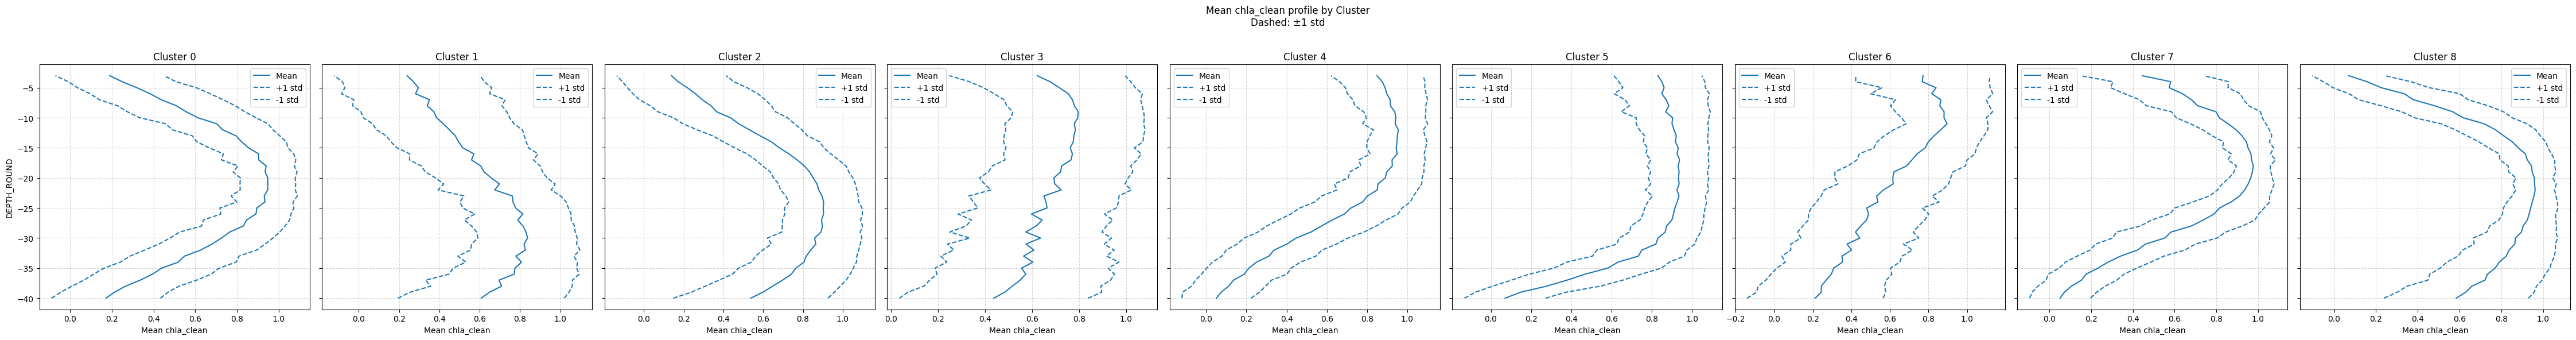

In [103]:
# Compute mean chla_clean profile per cluster and depth
cluster_chla_profile = (
    df_clustered
    .groupby(["cluster", "DEPTH_ROUND"])
    .agg([
        pl.col("chla_clean_norm").mean().alias("chla_clean_mean"),
        pl.col("chla_clean_norm").std().alias("chla_clean_std"),
    ])
    .sort(["cluster", "DEPTH_ROUND"])
)

# Get unique clusters and sort, ignoring None values
clusters = sorted([cl for cl in cluster_chla_profile["cluster"].unique().to_list() if cl is not None])

fig, axs = plt.subplots(1, len(clusters), figsize=(5 * len(clusters), 6), sharey=True)

if len(clusters) == 1:
    axs = [axs]  # Ensure axs is iterable

for idx, cl in enumerate(clusters):
    prof = cluster_chla_profile.filter(pl.col("cluster") == cl)
    mean = prof["chla_clean_mean"]
    std = prof["chla_clean_std"]
    depth = prof["DEPTH_ROUND"]
    axs[idx].plot(mean, depth, label="Mean", color="tab:blue")
    axs[idx].plot(mean + std, depth, linestyle="--", color="tab:blue", label="+1 std")
    axs[idx].plot(mean - std, depth, linestyle="--", color="tab:blue", label="-1 std")
    axs[idx].set_xlabel("Mean chla_clean")
    axs[idx].set_title(f"Cluster {cl}")
    axs[idx].grid(True, linestyle="--", alpha=0.5)
    if idx == 0:
        axs[idx].set_ylabel("DEPTH_ROUND")
    axs[idx].legend()

plt.suptitle("Mean chla_clean profile by Cluster\nDashed: ±1 std")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

C:\Users\flapet\AppData\Local\Temp\ipykernel_27628\2140933843.py:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["cluster", "DEPTH_ROUND"])


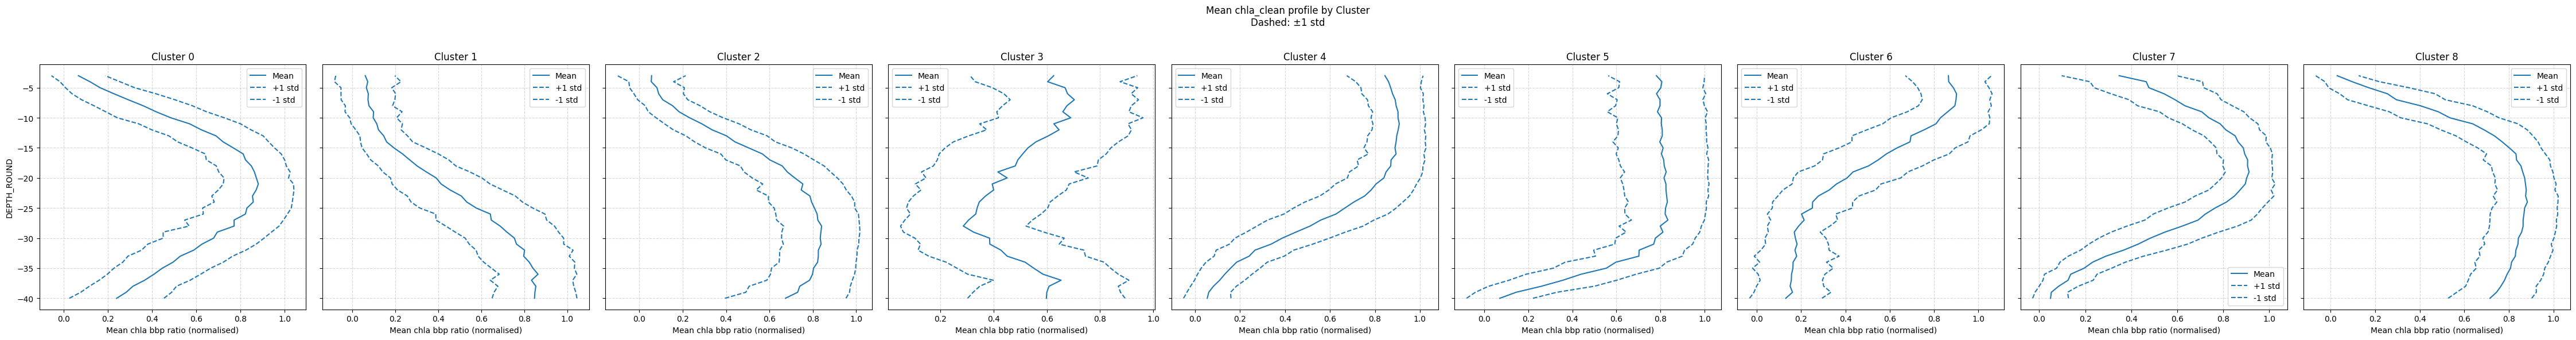

In [104]:
# Compute mean chla_clean profile per cluster and depth
cluster_chla_bbp_profile = (
    df_clustered
    .groupby(["cluster", "DEPTH_ROUND"])
    .agg([
        pl.col("chla_bbp_ratio_norm").mean().alias("chla_bbp_clean_mean"),
        pl.col("chla_bbp_ratio_norm").std().alias("chla_bbp_clean_std"),
    ])
    .sort(["cluster", "DEPTH_ROUND"])
)

# Get unique clusters and sort, ignoring None values
clusters = sorted([cl for cl in cluster_chla_profile["cluster"].unique().to_list() if cl is not None])

fig, axs = plt.subplots(1, len(clusters), figsize=(5 * len(clusters), 6), sharey=True)

if len(clusters) == 1:
    axs = [axs]  # Ensure axs is iterable

for idx, cl in enumerate(clusters):
    prof = cluster_chla_bbp_profile.filter(pl.col("cluster") == cl)
    mean = prof["chla_bbp_clean_mean"]
    std = prof["chla_bbp_clean_std"]
    depth = prof["DEPTH_ROUND"]
    axs[idx].plot(mean, depth, label="Mean", color="tab:blue")
    axs[idx].plot(mean + std, depth, linestyle="--", color="tab:blue", label="+1 std")
    axs[idx].plot(mean - std, depth, linestyle="--", color="tab:blue", label="-1 std")
    axs[idx].set_xlabel("Mean chla bbp ratio (normalised)")
    axs[idx].set_title(f"Cluster {cl}")
    axs[idx].grid(True, linestyle="--", alpha=0.5)
    if idx == 0:
        axs[idx].set_ylabel("DEPTH_ROUND")
    axs[idx].legend()

plt.suptitle("Mean chla_clean profile by Cluster\nDashed: ±1 std")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [105]:
# Count number of profiles per cluster and day_period
cluster_period_counts = (
    df_clustered
    .select(["profile_id", "cluster", "day_period"])
    .unique(subset=["profile_id"])
    .group_by(["cluster", "day_period"])
    .agg(pl.len().alias("n_profiles"))
    .sort(["cluster", "day_period"])
    .to_pandas()
)

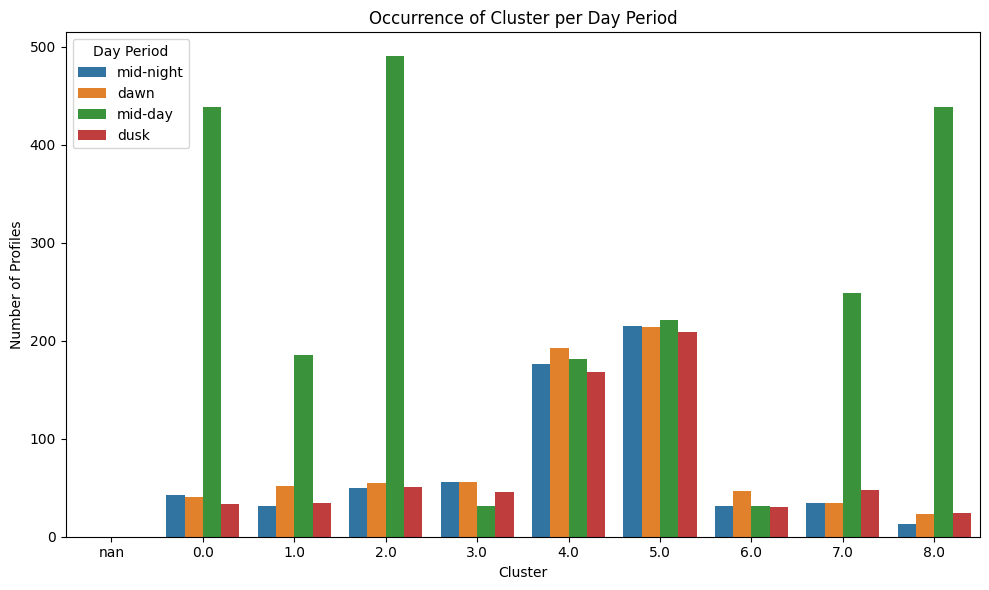

In [106]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_period_counts,
    x="cluster",
    y="n_profiles",
    hue="day_period",
    order=sorted(cluster_period_counts["cluster"].unique()),
    hue_order=["mid-night", "dawn", "mid-day", "dusk"]
)
plt.xlabel("Cluster")
plt.ylabel("Number of Profiles")
plt.title("Occurrence of Cluster per Day Period")
plt.legend(title="Day Period")
plt.tight_layout()
plt.show()

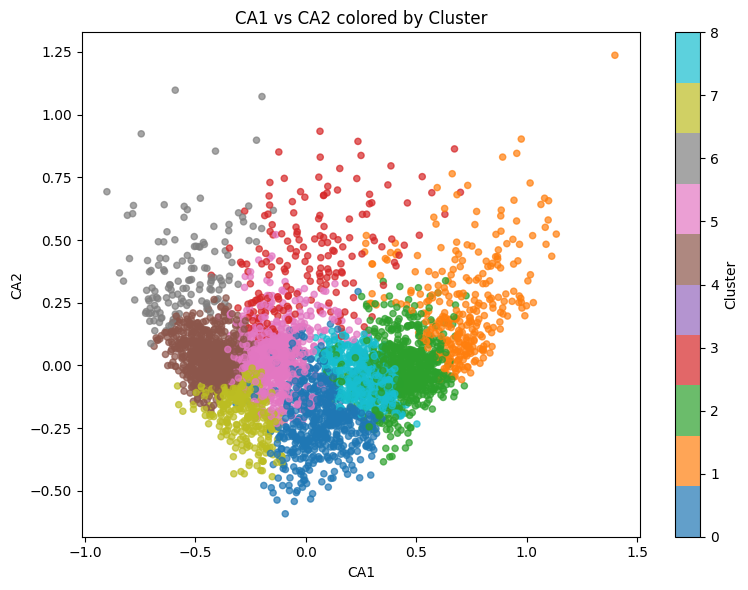

In [107]:
# Prepare DataFrame for plotting: CA1, CA2, and cluster for each profile_id
ca_cluster_df = (
    df_clustered
    .select(["profile_id", "CA1", "CA2", "cluster"])
    .unique(subset=["profile_id"])
    .to_pandas()
    .dropna(subset=["CA1", "CA2", "cluster"])
)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    ca_cluster_df["CA1"], ca_cluster_df["CA2"],
    c=ca_cluster_df["cluster"], cmap="tab10", s=20, alpha=0.7
)
plt.xlabel("CA1")
plt.ylabel("CA2")
plt.title("CA1 vs CA2 colored by Cluster")
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.show()

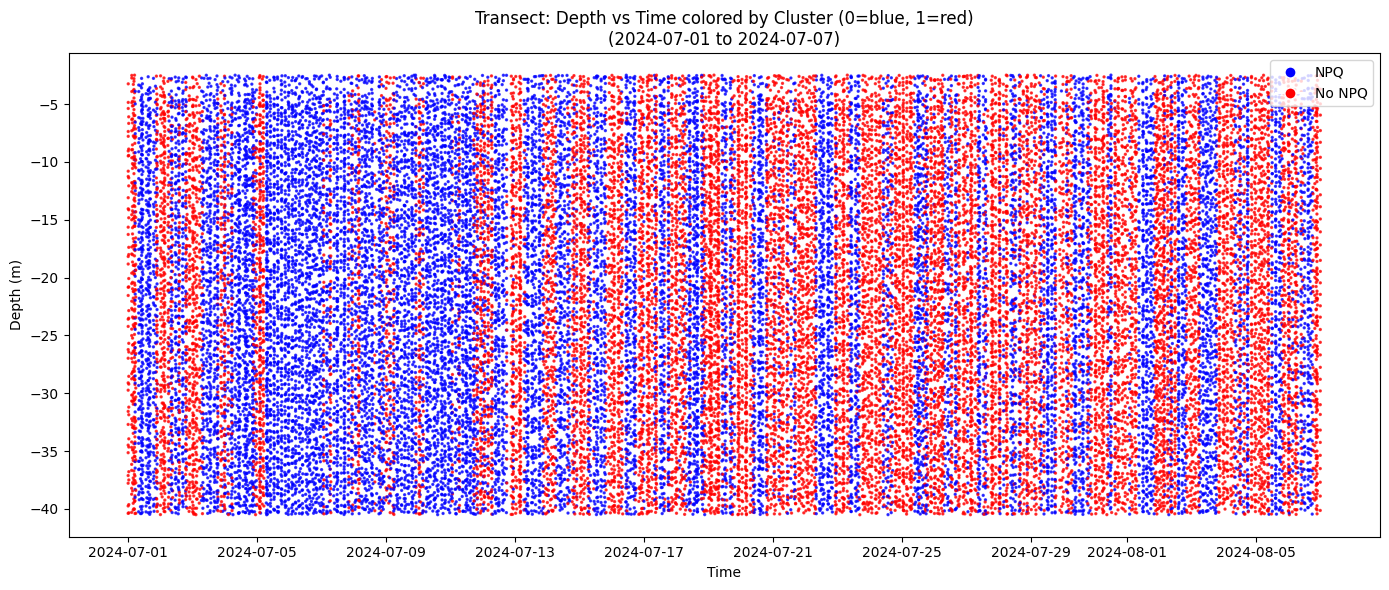

In [110]:
import pandas as pd

# Define the time window
start_date = pd.Timestamp("2024-07-01")
end_date = pd.Timestamp("2024-08-07")

# Filter data to the desired week
mask = (df_clustered["TIME"] >= start_date) & (df_clustered["TIME"] <= end_date)
df_week = df_clustered.filter(mask)

# Only plot clusters 0 and 1
df_week = df_week.filter(pl.col("cluster").is_in([0, 1, 2, 3, 4, 5, 6, 7, 8]))

# Map cluster to color
color_map = {0: "blue", 1: "blue", 2: "blue", 3: "blue", 4: "red", 5: "red", 6: "red", 7: "blue", 8: "blue"}
colors = df_week["cluster"].to_pandas().map(color_map)

plt.figure(figsize=(14, 6))
plt.scatter(
    df_week["TIME"].to_pandas(),
    df_week["DEPTH"].to_pandas(),
    c=colors,
    s=2,
    alpha=0.7
)
plt.gca() 
plt.xlabel("Time")
plt.ylabel("Depth (m)")
plt.title("Transect: Depth vs Time colored by Cluster (0=blue, 1=red)\n(2024-07-01 to 2024-07-07)")
from matplotlib.lines import Line2D
plt.legend(handles=[
    Line2D([0], [0], marker='o', color='w', label='NPQ', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='No NPQ', markerfacecolor='red', markersize=8)
])
plt.tight_layout()
plt.show()

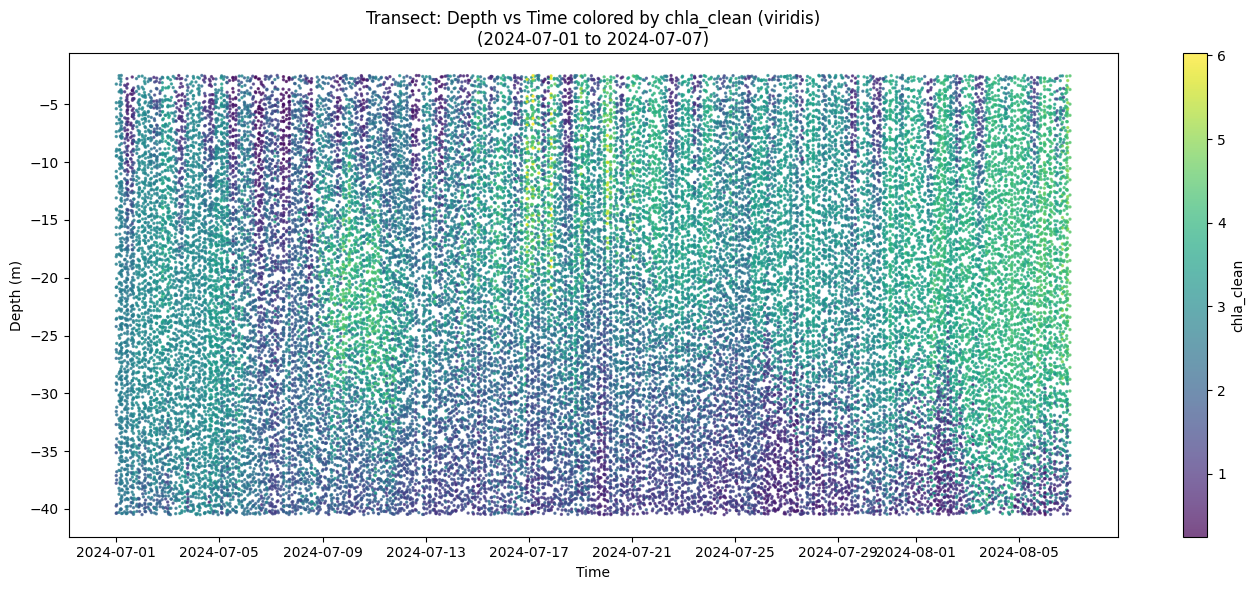

In [111]:
plt.figure(figsize=(14, 6))
sc = plt.scatter(
    df_week["TIME"].to_pandas(),
    df_week["DEPTH"].to_pandas(),
    c=df_week["chla_clean"].to_pandas(),
    cmap="viridis",
    s=2,
    alpha=0.7
)
plt.xlabel("Time")
plt.ylabel("Depth (m)")
plt.title("Transect: Depth vs Time colored by chla_clean (viridis)\n(2024-07-01 to 2024-07-07)")
cbar = plt.colorbar(sc, label="chla_clean")
plt.tight_layout()
plt.show()

# Training a Classifier on cluster 0

In [112]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import pandas as pd
import numpy as np


# Convert to pandas DataFrame for sklearn/xgboost
df_ml = df_clustered.select([
    "bbp_clean", "DATE", "DEPTH", "TEMP", "chla_clean", "cluster"
]).filter(pl.col("cluster").is_between(4, 6, closed="both")).to_pandas().dropna()

# Feature engineering: convert DATE to ordinal (numeric)
df_ml["DATE_ORD"] = pd.to_datetime(df_ml["DATE"]).map(pd.Timestamp.toordinal)

X = df_ml[["bbp_clean", "DATE_ORD", "DEPTH", "TEMP"]]
y = df_ml["chla_clean"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the XGBoost regressor
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Evaluate
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")

# Optional: cross-validation
cv_scores = cross_val_score(xgb, X, y, cv=5, scoring='r2')
print(f"Cross-validated R2: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Test MSE: 0.0875
Test R2: 0.9082
Cross-validated R2: 0.7877 ± 0.0605


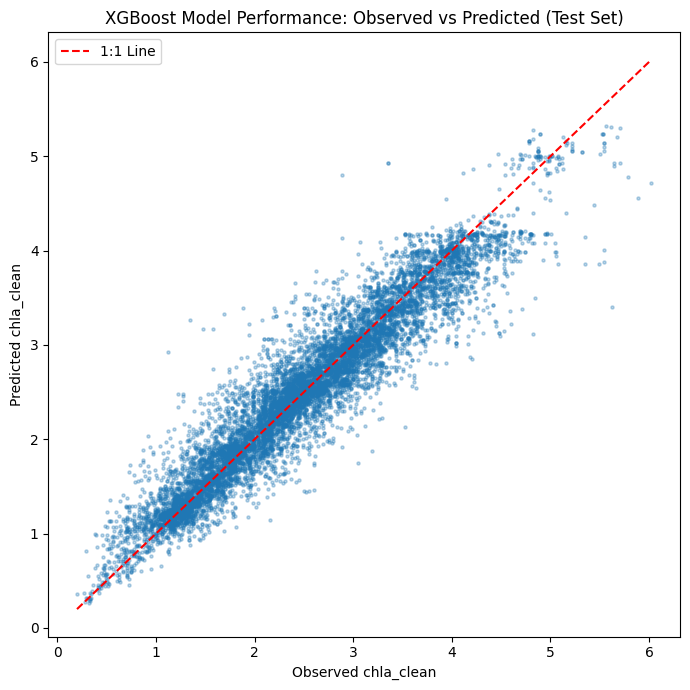

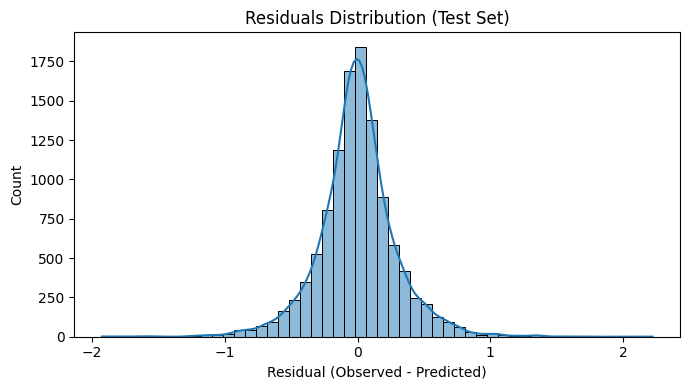

In [ ]:
# Scatter plot: Observed vs Predicted chla_clean on test set
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.3, s=5)
plt.xlabel("Observed chla_clean")
plt.ylabel("Predicted chla_clean")
plt.title("XGBoost Model Performance: Observed vs Predicted (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="1:1 Line")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Residual (Observed - Predicted)")
plt.title("Residuals Distribution (Test Set)")
plt.tight_layout()
plt.show()

In [119]:
# Predict chla_clean for cluster 1 using the trained XGBoost model

# Select cluster 1 rows and prepare features
df_cluster1 = (
    df_clustered
    .select(["profile_id", "bbp_clean", "DATE", "DEPTH", "TEMP", "chla_clean", "cluster"])
    .filter(~pl.col("cluster").is_in([4, 5, 6]))
    .to_pandas()
    .dropna()
)
df_cluster1["DATE_ORD"] = pd.to_datetime(df_cluster1["DATE"]).map(pd.Timestamp.toordinal)
X1 = df_cluster1[["bbp_clean", "DATE_ORD", "DEPTH", "TEMP"]]

# Predict chla_clean using the trained model
df_cluster1["chla_clean_pred"] = xgb.predict(X1)

# Merge predictions back to polars DataFrame using profile_id and all relevant columns
preds_pl = pl.from_pandas(df_cluster1[["profile_id", "bbp_clean", "DATE", "DEPTH", "TEMP", "chla_clean_pred"]])

# Ensure DATE is of type date for join compatibility
preds_pl = preds_pl.with_columns(
    pl.col("DATE").dt.date().alias("DATE")
)

# Join predictions to df_clustered
df_clustered = (
    df_clustered
    .join(
        preds_pl.rename({"chla_clean_pred": "chla_clean_new"}),
        on=["profile_id", "bbp_clean", "DATE", "DEPTH", "TEMP"],
        how="left"
    )
    .with_columns(
        pl.when(pl.col("chla_clean_new").is_not_null())
        .then(pl.col("chla_clean_new"))
        .otherwise(pl.col("chla_clean"))
        .alias("chla_clean_predicted")
    )
    .drop("chla_clean_new")
)

In [120]:
df_week2 = df_clustered.filter(mask)

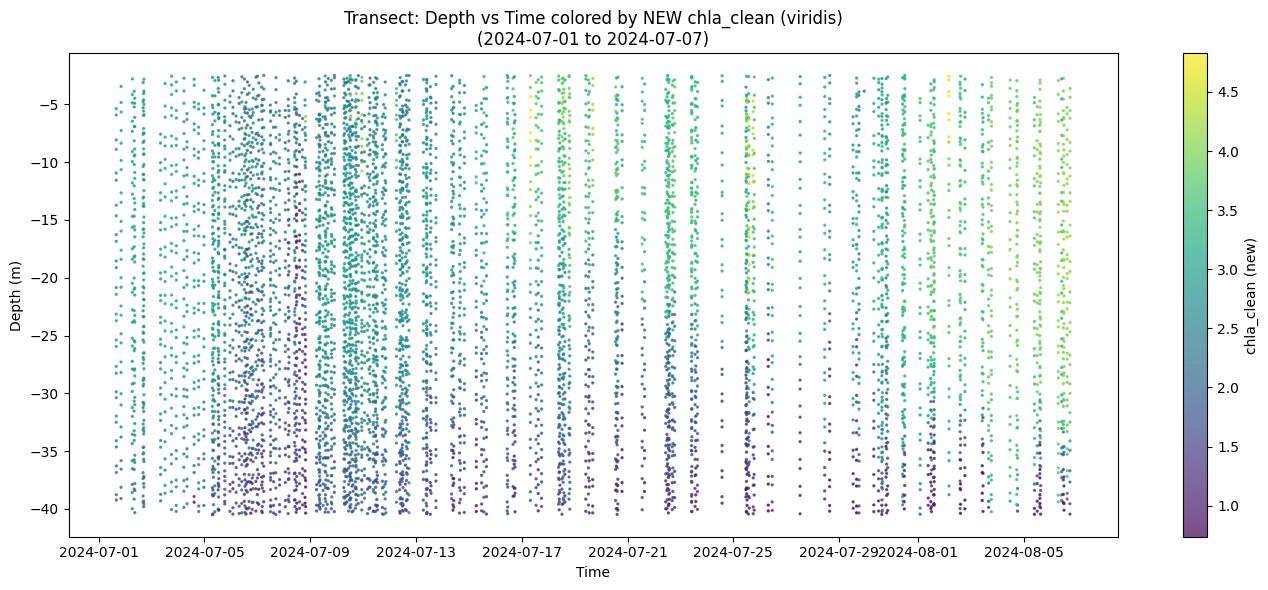

In [121]:

# Filter data to the desired week from the updated df_clustered (with chla_clean_predicted)
df_week2 = (
    df_clustered
    .filter(
        (pl.col("TIME") >= start_date) &
        (pl.col("TIME") <= end_date) &
        (pl.col("cluster").is_in([0, 1]))
    )
)

plt.figure(figsize=(14, 6))
sc = plt.scatter(
    df_week2["TIME"].to_pandas(),
    df_week2["DEPTH"].to_pandas(),
    c=df_week2["chla_clean_predicted"].to_pandas(),
    cmap="viridis",
    s=2,
    alpha=0.7
)
plt.xlabel("Time")
plt.ylabel("Depth (m)")
plt.title("Transect: Depth vs Time colored by NEW chla_clean (viridis)\n(2024-07-01 to 2024-07-07)")
cbar = plt.colorbar(sc, label="chla_clean (new)")
plt.tight_layout()
plt.show()

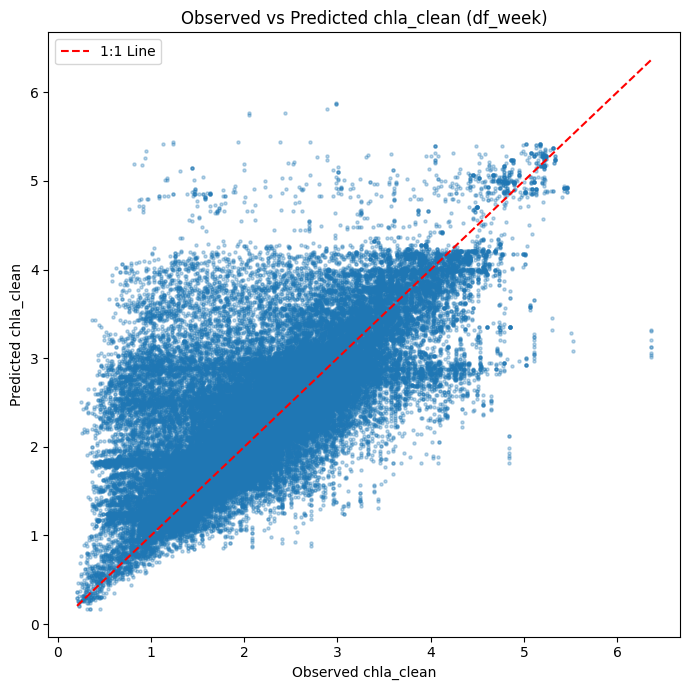

In [122]:
plt.figure(figsize=(7, 7))
plt.scatter(
    df_cluster1["chla_clean"],
    df_cluster1["chla_clean_pred"],
    alpha=0.3, s=5
)
plt.xlabel("Observed chla_clean")
plt.ylabel("Predicted chla_clean")
plt.title("Observed vs Predicted chla_clean (df_week)")
plt.plot([df_cluster1["chla_clean"].min(), df_cluster1["chla_clean"].max()],
         [df_cluster1["chla_clean"].min(), df_cluster1["chla_clean"].max()],
         color="red", linestyle="--", label="1:1 Line")
plt.legend()
plt.tight_layout()
plt.show()

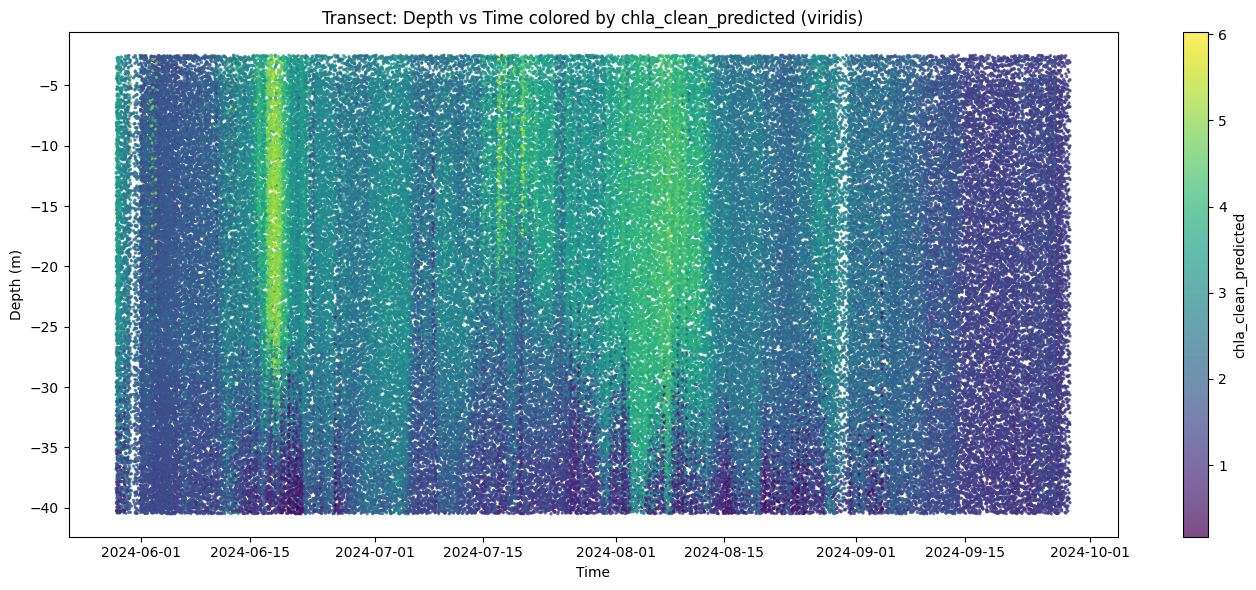

In [123]:
plt.figure(figsize=(14, 6))
sc = plt.scatter(
    df_clustered["TIME"].to_pandas(),
    df_clustered["DEPTH"].to_pandas(),
    c=df_clustered["chla_clean_predicted"].to_pandas(),
    cmap="viridis",
    s=2,
    alpha=0.7
)
plt.xlabel("Time")
plt.ylabel("Depth (m)")
plt.title("Transect: Depth vs Time colored by chla_clean_predicted (viridis)")
cbar = plt.colorbar(sc, label="chla_clean_predicted")
plt.tight_layout()
plt.show()

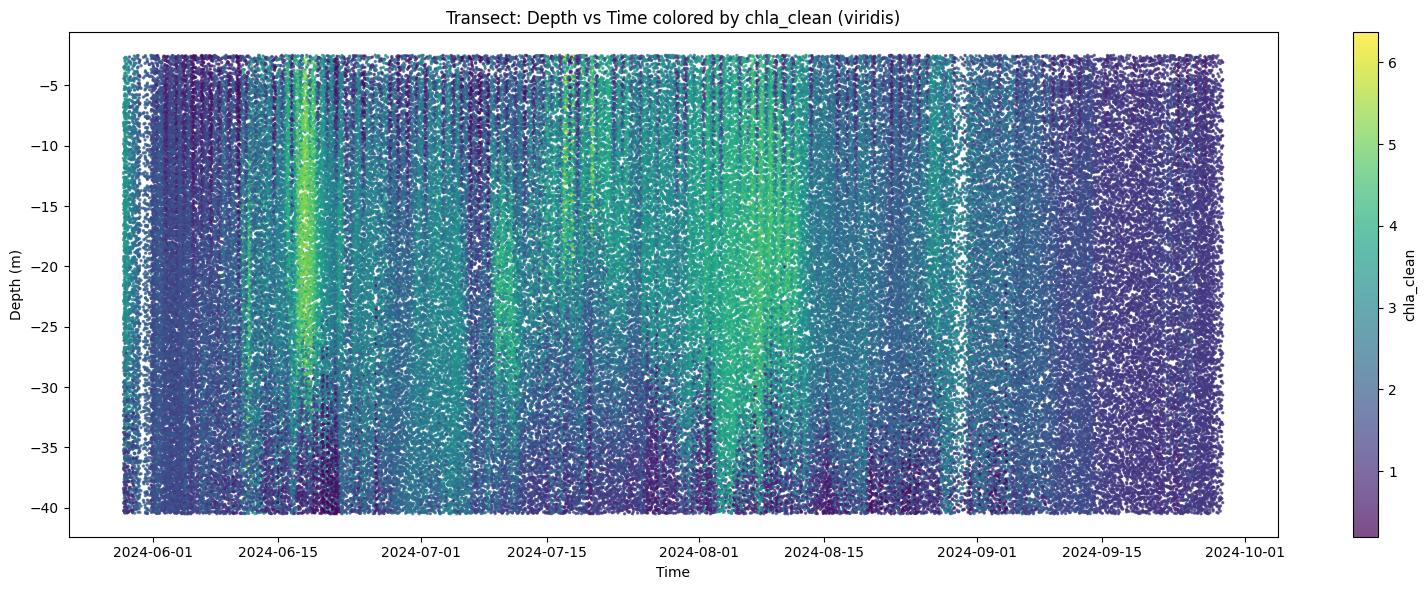

In [124]:
plt.figure(figsize=(16, 6))
sc = plt.scatter(
    df_clustered["TIME"].to_pandas(),
    df_clustered["DEPTH"].to_pandas(),
    c=df_clustered["chla_clean"].to_pandas(),
    cmap="viridis",
    s=2,
    alpha=0.7
)
plt.xlabel("Time")
plt.ylabel("Depth (m)")
plt.title("Transect: Depth vs Time colored by chla_clean (viridis)")
cbar = plt.colorbar(sc, label="chla_clean")
plt.tight_layout()
plt.show()

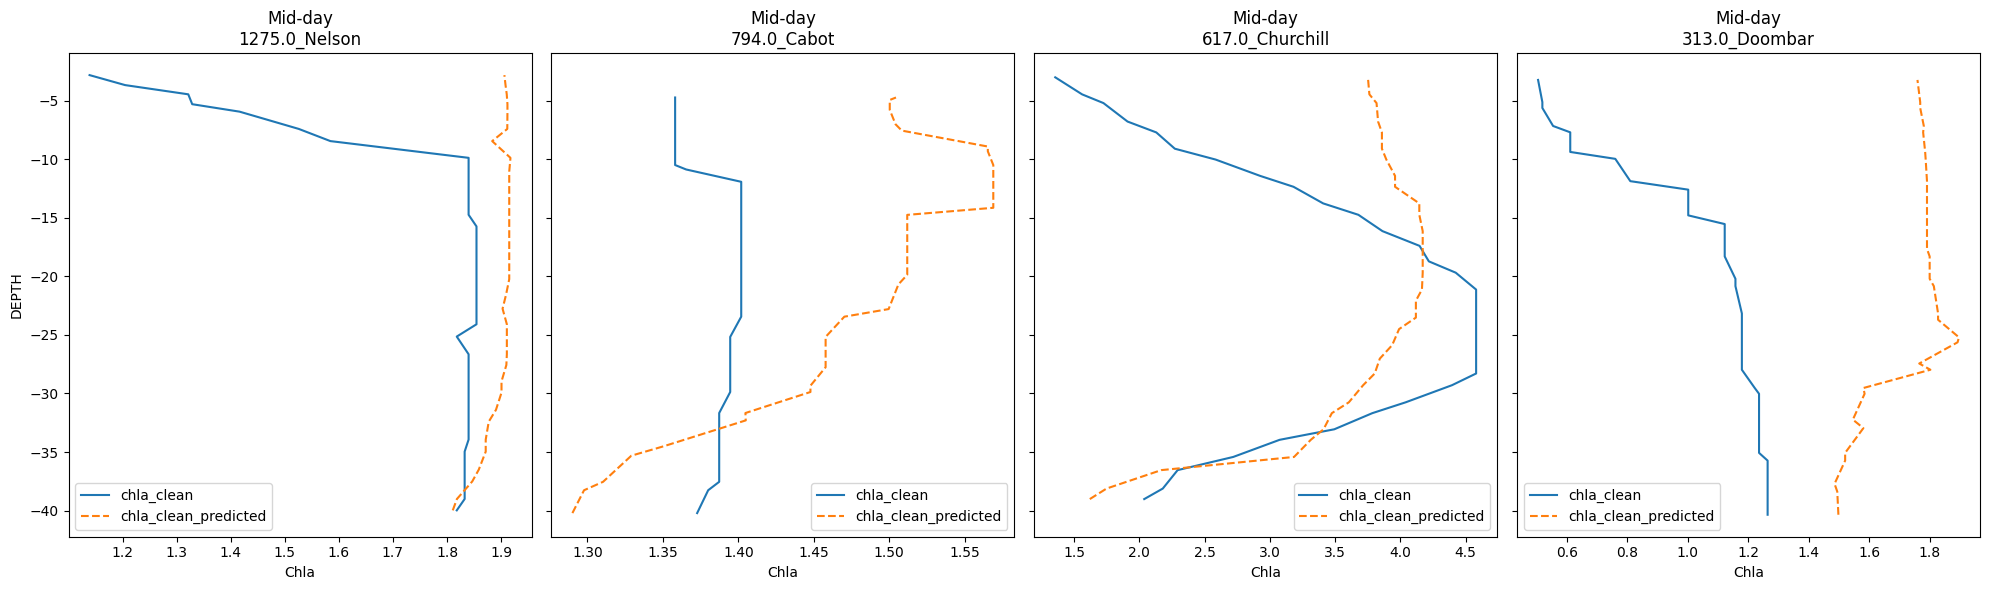

In [125]:
import random

# Select a few random mid-day profiles
midday_profiles = (
    df_clustered
    .filter(pl.col("day_period") == "mid-day")
    .select("profile_id")
    .unique()
    .to_series()
    .to_list()
)

# Pick up to 4 random profile_ids for plotting
plot_profiles = random.sample(midday_profiles, min(4, len(midday_profiles)))

fig, axs = plt.subplots(1, len(plot_profiles), figsize=(5 * len(plot_profiles), 6), sharey=True)

if len(plot_profiles) == 1:
    axs = [axs]

for i, pid in enumerate(plot_profiles):
    prof = df_clustered.filter(pl.col("profile_id") == pid).sort("DEPTH")
    axs[i].plot(prof["chla_clean"], prof["DEPTH"], label="chla_clean", color="tab:blue")
    axs[i].plot(prof["chla_clean_predicted"], prof["DEPTH"], label="chla_clean_predicted", color="tab:orange", linestyle="--")
    axs[i].invert_yaxis()
    axs[i].set_xlabel("Chla")
    axs[i].set_title(f"Mid-day\n{pid}")
    if i == 0:
        axs[i].set_ylabel("DEPTH")
    axs[i].legend()

plt.tight_layout()
plt.show()